<a href="https://colab.research.google.com/github/smiling621/DermaSoul/blob/main/skin_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = '/content/drive/MyDrive/dermasoul_final'
print(os.listdir(base_path))

['skin_dataset__.zip', 'skin_dataset_extracted', 'my_skin_model.h5', 'dataset']


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/dermasoul_final/skin_dataset__.zip'
extract_path = '/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os
print(os.path.exists(extract_path))
print(os.listdir(extract_path))


True
['skin_dataset__']


In [ ]:
import os

# Set your dataset root path here
dataset_path = '/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset'

# If you have train, test, valid folders:
splits = ['train', 'test', 'valid']
categories = ['normal', 'dry', 'oil']

for split in splits:
    print(f'--- {split.upper()} ---')
    for category in categories:
        folder = os.path.join(dataset_path, split, category)
        if os.path.exists(folder):
            count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f'{category}: {count} images')
        else:
            print(f'{category}: Folder not found')
    print()


--- TRAIN ---
normal: 452 images
dry: 452 images
oil: 452 images

--- TEST ---
normal: 9 images
dry: 9 images
oil: 9 images

--- VALID ---
normal: 19 images
dry: 19 images
oil: 19 images



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
import os

# Augmentation settings
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Path to your train folders
train_base = '/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/train'

# Categories to augment
categories = ['dry', 'oil']
# Number of augmented images per class
augment_target = 226

for category in categories:
    folder_path = os.path.join(train_base, category)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\nAugmenting '{category}'... Total original: {len(images)}")

    saved = 0
    for img_name in images:
        if saved >= augment_target:
            break

        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate 1 new image per original
        for batch in augmentor.flow(x, batch_size=1):
            new_filename = f"aug_{saved}_{img_name}"
            save_img(os.path.join(folder_path, new_filename), batch[0])
            saved += 1
            break  # Only one augmentation per image

    print(f"Generated {saved} augmented images for '{category}'")



Augmenting 'dry'... Total original: 452
Generated 226 augmented images for 'dry'

Augmenting 'oil'... Total original: 452
Generated 226 augmented images for 'oil'


In [ ]:
import os
import random
import shutil

def downsample_folder_no_backup(folder_path, target_count):
    # List all images in folder
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Total images before downsampling in {folder_path}: {len(images)}")

    if len(images) <= target_count:
        print(f"No downsampling needed, already {len(images)} <= {target_count}\n")
        return

    # Randomly select images to keep
    images_to_keep = set(random.sample(images, target_count))

    # Delete images not in keep list
    deleted_count = 0
    for img in images:
        if img not in images_to_keep:
            os.remove(os.path.join(folder_path, img))
            deleted_count += 1

    print(f"Deleted {deleted_count} images. Remaining images: {len(os.listdir(folder_path))}\n")

def delete_all_images(folder_path):
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    deleted_count = 0
    for img in images:
        os.remove(os.path.join(folder_path, img))
        deleted_count += 1
    print(f"Deleted all {deleted_count} images from {folder_path}\n")

# Set your base dataset path here
base_path = '/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset'
downsample_folder_no_backup(os.path.join(base_path, 'train', 'normal'), 452)
downsample_folder_no_backup(os.path.join(base_path, 'test', 'normal'), 9)
downsample_folder_no_backup(os.path.join(base_path, 'valid', 'normal'), 19)


Total images before downsampling in /content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/train/normal: 1104
Deleted 652 images. Remaining images: 452

Total images before downsampling in /content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/test/normal: 59
Deleted 50 images. Remaining images: 9

Total images before downsampling in /content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/valid/normal: 111
Deleted 92 images. Remaining images: 19



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, VGG16, MobileNetV3Small, EfficientNetB0, EfficientNetV2B0, ResNet50
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skimage import exposure
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as gb
import seaborn as sns

In [ ]:
# Constants and Hyperparameters
resize = 224
learning_rate = 1e-4
seed = 107
INIT_LR = 1e-4
EPOCHS = 30
BS = 64

# Directory paths
base_dir =  '/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset'
TRAIN_DIR = os.path.join(base_dir, 'train')
TEST_DIR = os.path.join(base_dir, 'test')
VALID_DIR = os.path.join(base_dir, 'valid')

# Check if directories exist
assert os.path.exists(TRAIN_DIR), 'Could not find' + TRAIN_DIR
assert os.path.exists(TEST_DIR), 'Could not find' + TEST_DIR
assert os.path.exists(VALID_DIR), 'Could not find' + VALID_DIR

In [ ]:
ls -la "/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/train"


total 12
drwx------ 2 root root 4096 Jul 24 14:57 dry/
drwx------ 2 root root 4096 Jul 24 14:57 normal/
drwx------ 2 root root 4096 Jul 24 14:57 oil/


In [ ]:
!rm -rf "/content/drive/MyDrive/dermasoul_final/skin_dataset_extracted/skin_dataset__/skin_dataset/train/normal_backup"


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/dermasoul_final/skin_dataset1_extracted/skin_dataset__/skin_dataset/train'))


['dry', 'normal', 'oil']


100%|██████████| 3/3 [00:00<00:00, 67.50it/s]


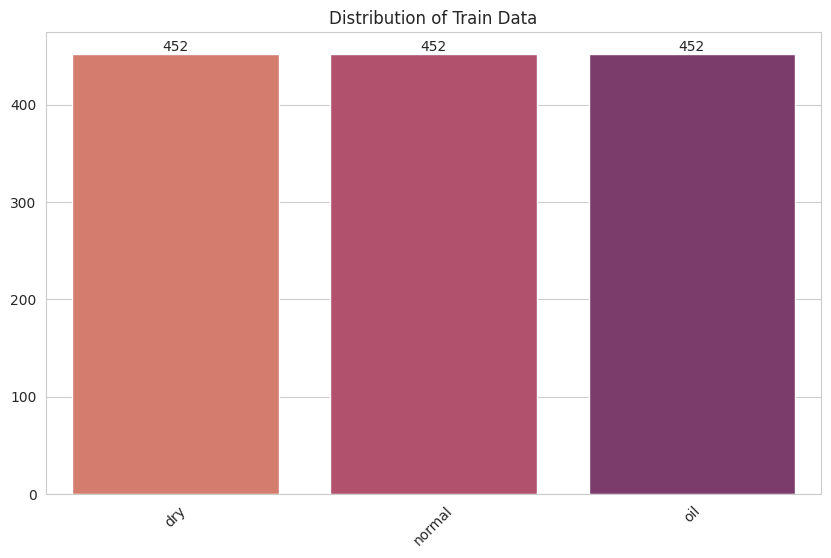

1356


100%|██████████| 452/452 [00:02<00:00, 161.35it/s]


In [ ]:
# Data visualization
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR + '/' + f + '/*'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

# sns.barplot(x=categories, y=class_count).set_title("Distribution of Train Data")
# plt.show()

# Using seaborn for barplot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categories, y=class_count, hue=categories, palette='flare', dodge=False)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Train Data')
plt.xticks(rotation=45)

# Check if legend exists before trying to remove it
if ax.legend_ is not None:
    ax.legend_.remove()

plt.show()
print(train_exm)


# Data loading and preprocessing
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
len(labels)

1356

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{np.str_('dry'): np.int64(452),
 np.str_('normal'): np.int64(452),
 np.str_('oil'): np.int64(452)}

In [ ]:
# Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# Data Augmentation
AugmentedData = ImageDataGenerator(
    zoom_range=0.15, #Randomly zooms the images zoom in up to 15%
    rotation_range=360,  # Randomly rotates the images Set to 360 to cover all possible rotations
    width_shift_range=0.1, #Randomly shifts the images horizontally
    height_shift_range=0.1, #Randomly shifts the images vertically
    #shear transformation will be applied with a maximum shear angle of 0.15 degreesto 0.20. shear_range=(0.15, 0.2)
    shear_range=0.15, #A positive shear angle tilts the image to the right, while a negative shear angle tilts it to the left.
    #handle variations in facial structure
    brightness_range=[0.5, 1.5], #brightness of the images can be adjusted to be as dark as 50% of the original brightness or as bright as 150%
    # rescale=1./255,  #rescaling for data preprocessing pixel values in the range [0, 255], dividing by 255 ensures that the values are scaled to be between 0 and 1 NORMALIZATION
    horizontal_flip=True, #Randomly flips the images horizontally
    fill_mode="nearest" #Strategy for filling in newly created pixels
    #Options include "nearest" (fill with nearest pixel value) or others like "constant," "reflect," or "wrap."
)

# Custom function for contrast stretching
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98)) #2nd and 98th percentiles of pixel intensities in the image.
    return exposure.rescale_intensity(image, in_range=(p2, p98)) #skimage library & exposure

# Applying contrast stretching during data augmentation
AugmentedData.preprocessing_function = contrast_stretching

# contrast_stretching=(0.5, 2.0), #contrast of the images can be adjusted to be as low as 50% of the original contrast or as high as 100%

In [ ]:
# Model names dictionary
model_dict = {
    'VGG16': VGG16,
    'MobileNetV2' : MobileNetV2,
    'MobileNetV3Small': MobileNetV3Small,
    'ResNet50': ResNet50,
    'EfficientNetB0': EfficientNetB0,
    'EfficientNetV2B0': EfficientNetV2B0
}

In [ ]:
# Choose the desired model
model_name = 'MobileNetV2'
base_model = model_dict[model_name](weights='imagenet', include_top=False, input_shape=(resize, resize, 3))
base_model.summary()

# (A simple CNN as the Head model) a custom head for classification
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.25)(head_model)
head_model = Dense(3, activation="softmax")(head_model)

# Combine the base model and head model
model = Model(inputs=base_model.input, outputs=head_model)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (1084, 224, 224, 3)
Shape of y_train: (1084, 3)

Shape of x_test: (272, 224, 224, 3)
Shape of y_test: (272, 3)


In [ ]:
# Determine the loss function based on the number of classes
if len(categories) > 2:
    loss_function = "categorical_crossentropy"
else:
    loss_function = "binary_crossentropy"

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
import math

H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=math.ceil(len(trainX) / BS),
    validation_data=(testX, testY),
    validation_steps=math.ceil(len(testX) / BS),
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.5564 - loss: 0.9172 - val_accuracy: 0.8713 - val_loss: 0.4711
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.8764 - loss: 0.3949 - val_accuracy: 0.9081 - val_loss: 0.3192
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.8928 - loss: 0.3077 - val_accuracy: 0.9228 - val_loss: 0.2675
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9293 - loss: 0.2193 - val_accuracy: 0.9191 - val_loss: 0.2460
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9336 - loss: 0.2298 - val_accuracy: 0.9375 - val_loss: 0.2243
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9323 - loss: 0.1925 - val_accuracy: 0.9449 - val_loss: 0.2090
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.9364 - loss: 0.1952 - val_accuracy: 0.9522 - val_loss: 0.1979
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9326 - loss: 0.1897 - val_accuracy: 0.9449 - val_lo

In [ ]:
hist_df = pd.DataFrame(H.history)
with open(f'{model_name.lower()}_history.json', mode='w') as f:
    hist_df.to_json(f)

[INFO] evaluating network...
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        91
           1       1.00      0.96      0.98        91
           2       0.94      0.93      0.94        90

    accuracy                           0.95       272
   macro avg       0.95      0.95      0.95       272
weighted avg       0.95      0.95      0.95       272



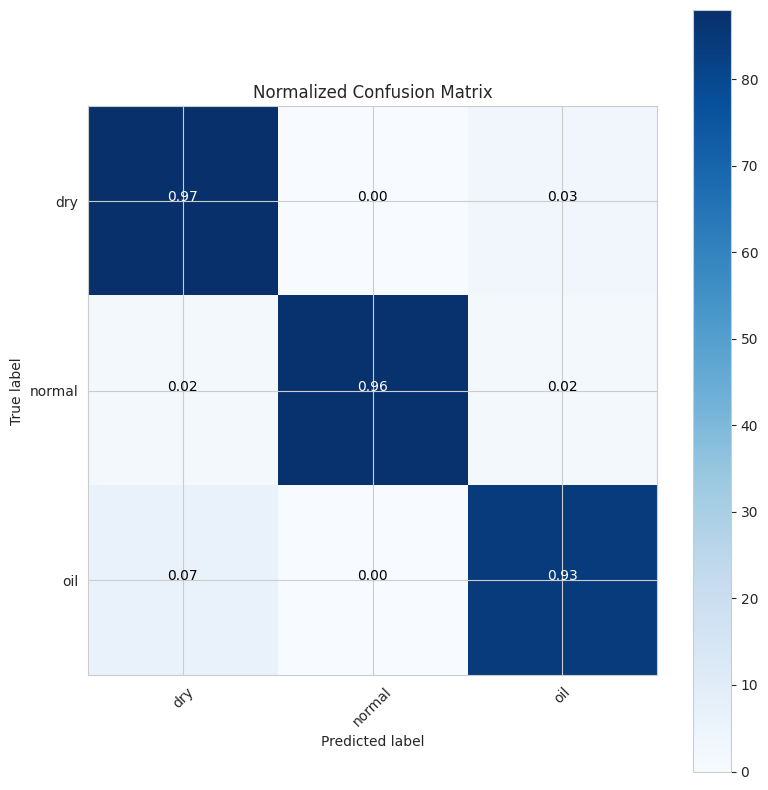

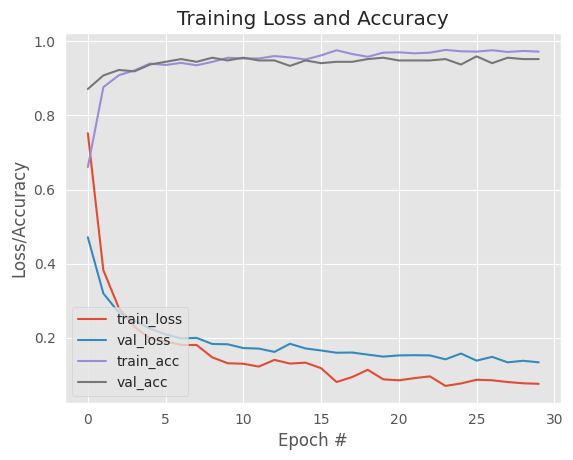

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Evaluate the model
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs))

# Generate confusion matrix
confusion_mtx = confusion_matrix(testY.argmax(axis=1), predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=categories, normalize=True, title='Normalized Confusion Matrix')
plt.show()

# Plot training history
N = EPOCHS

plt.style.use("ggplot")
sns.set_palette("husl")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
import os

model_dir = "/content/drive/MyDrive/dermasoul_final"
for f in os.listdir(model_dir):
    if f.endswith(".h5"):
        print("✔ Found model file:", f)


In [ ]:
from keras.models import load_model
model.save("/content/drive/MyDrive/dermasoul_final/my_skin_model.h5")



In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/dermasoul_final/my_skin_model.h5')
